# prerequisites:
* Install gtts: !pip install gtts
* Upgrade to Tensorflow2.0
* Assign the train_caption path at train_cation variable,
* set ckpt-4 checkpoint path as checkpoint_path and pass the path of image at Image_path
* Before importing the "image_cap", be sure it's on the root folder



In [1]:
from image_cap import *

Using TensorFlow backend.


In [2]:
def predict(train_captions_path, checkpoint_path, Image_path ):
    dbfile = open(train_captions_path, 'rb')      
    train_captions = pickle.load(dbfile)  
    dbfile.close() 


    # Choose the top 5000 words from the vocabulary
    top_k = 5000
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                      oov_token="<unk>",
                                                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
    tokenizer.fit_on_texts(train_captions)
    train_seqs = tokenizer.texts_to_sequences(train_captions)


    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'


    # Create the tokenized vectors
    train_seqs = tokenizer.texts_to_sequences(train_captions)

    # Pad each vector to the max_length of the captions
    # If you do not provide a max_length value, pad_sequences calculates it automatically
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


    # Calculates the max_length, which is used to store the attention weights
    max_length = calc_max_length(train_seqs)


    #restoring the model
    checkpoint_path = checkpoint_path
    #tf.compat.v2.keras.callbacks.ModelCheckpoint
    ckpt = tf.train.Checkpoint(encoder=encoder,
                               decoder=decoder,
                               optimizer = optimizer)
    ckpt.restore(checkpoint_path)

    
    def evaluate(image):
        attention_plot = np.zeros((max_length, attention_features_shape))

        hidden = decoder.reset_state(batch_size=1)

        temp_input = tf.expand_dims(load_image(image)[0], 0)
        img_tensor_val = image_features_extract_model(temp_input)
        img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

        features = encoder(img_tensor_val)

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
        result = []

        for i in range(max_length):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

            predicted_id = tf.argmax(predictions[0]).numpy()
            result.append(tokenizer.index_word[predicted_id])

            if tokenizer.index_word[predicted_id] == '<end>':
                return result, attention_plot

            dec_input = tf.expand_dims([predicted_id], 0)

        attention_plot = attention_plot[:len(result), :]
        return result, attention_plot

    
    new_img =  Image_path

    result, attention_plot = evaluate(new_img)
    for i in result:
        if i=="<unk>":
            result.remove(i)
        else:
            pass
    
    print('I guess: ', ' '.join(result).rsplit(' ', 1)[0])

    #real_caption = ' '.join(result).rsplit(' ', 1)[0]
    plot_attention(new_img, result, attention_plot)
    
    image_plot(new_img)
    
    tts = gTTS(' '.join(result).rsplit(' ', 1)[0]) #Provide the string to convert to speech
    tts.save('1.mp3')#save the string converted to speech as a .wav file
    sound_file = './1.mp3'
    return Audio(sound_file, autoplay=True) 
    Audio('./1.mp3', autoplay=True) 






I guess:  a white dog is running in the grass with a yellow toy in its mouth


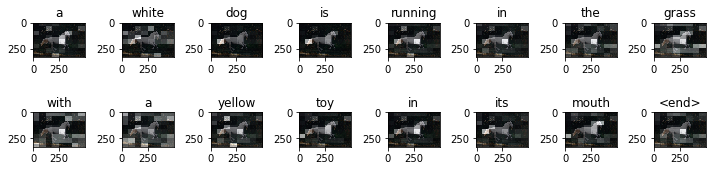

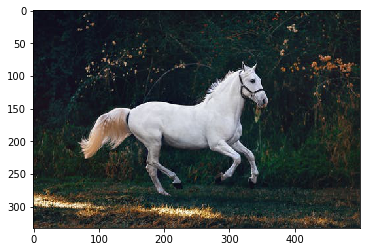

In [11]:
#train_captions_path, checkpoint_path, Image_path
predict('./train_captions',"D:/Self Case Study/DL/Flickr8k/final_checkpoint_20epochs/content/checkpoints/train/ckpt-4",'C:/Users/Shritam/Desktop/pexels-photo-1996333.jpeg' )